In [2]:
!nvidia-smi

Mon Aug 12 01:06:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1080      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   43C    P8             21W /  270W |    1703MiB /   8192MiB |     11%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import urllib
import zipfile
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
import random

In [4]:
if torch.cuda.is_available():
    print('CUDA is available. GPU will be used.')
    device = torch.device('cuda')

CUDA is available. GPU will be used.


In [5]:
# Load NIfTI image
def load_nifti(file_path):
    nifti_img = nib.load(file_path)
    image_data = nifti_img.get_fdata()
    print('min', np.min(image_data))
    print('max', np.max(image_data))
    rot_image = np.rot90(image_data, k=1, axes=(0, 2))
    swapped_axis_img = np.swapaxes(rot_image, 1, 2)
    data = swapped_axis_img / 255.
    return data.astype(np.float32)


def unsqueeze_tensor(image, dim=5):
    image_tensor = torch.tensor(image, dtype=torch.float32)
    # add dimensions to the start of the tensor until desired dim is reached
    while len(image_tensor.shape) < dim:
        image_tensor = image_tensor.unsqueeze(0)

    return image_tensor


def downsample_image(image, scale_factor=0.5):
    # Convert numpy array to a PyTorch tensor
    image_tensor = torch.tensor(image, dtype=torch.float32)

    image_tensor = unsqueeze_tensor(image_tensor, dim=5)

    # Downsample the image using F.interpolate
    downsampled_tensor = F.interpolate(image_tensor, scale_factor=scale_factor, mode='trilinear', align_corners=True)

    # Remove the added batch dimension if it was added
    downsampled_tensor = downsampled_tensor.squeeze()  # Shape: (C, D', H', W')

    return downsampled_tensor


# Spatial Transformer Network for warping the moving image
def stn(moving_image, flow):
    # Here, we use PyTorch's grid_sample to warp the moving image using the flow field
    D, H, W = moving_image.shape[2:]
    # Create mesh grid
    grid_d, grid_h, grid_w = torch.meshgrid(
        torch.arange(D, dtype=torch.float32, device=moving_image.device),
        torch.arange(H, dtype=torch.float32, device=moving_image.device),
        torch.arange(W, dtype=torch.float32, device=moving_image.device)
    )
    grid = torch.stack((grid_w, grid_h, grid_d), dim=0)  # Shape: (3, D, H, W)
    grid = grid.unsqueeze(0).expand(moving_image.size(0), -1, -1, -1, -1)  # Shape: (B, 3, D, H, W)
    grid = grid + flow
    grid = grid.permute(0, 2, 3, 4, 1)  # Change shape to (B, D, H, W, 3) for grid_sample

    # Normalize grid to [-1, 1]
    grid[..., 0] = 2.0 * grid[..., 0] / (W - 1) - 1.0
    grid[..., 1] = 2.0 * grid[..., 1] / (H - 1) - 1.0
    grid[..., 2] = 2.0 * grid[..., 2] / (D - 1) - 1.0

    # Sample pixels from moving image
    warped_image = F.grid_sample(moving_image, grid, mode='bilinear', padding_mode='border', align_corners=True)
    return warped_image


In [6]:
def load_data(jsonData, dataFolderPath, training_or_test):
    images = []
    for sample in jsonData[training_or_test]:
        imagePath = dataFolderPath + sample['image'].removeprefix('.')
        images.append(imagePath)

    return images

In [7]:
# download dataset if training on colab
colab = False

if colab:
    filename = 'AbdomenCTCT.zip'
    if not os.path.exists(filename):
        url = 'https://cloud.imi.uni-luebeck.de/s/32WaSRaTnFk2JeT/download/AbdomenCTCT.zip'
        urllib.request.urlretrieve(url, filename)

        # extract files
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall('./data/')

In [8]:
#load data
with open('./data/AbdomenCTCT/AbdomenCTCT_dataset.json', 'r') as file:
    data_json = json.load(file)
dataFolder = './data/AbdomenCTCT'
image_paths = load_data(data_json, dataFolder, 'training')

In [9]:
# Split the dataset
train_images, temp_images = train_test_split(image_paths, test_size=0.3, random_state=42)
val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

print(f"Training set: {len(train_images)} images")
print(f"Validation set: {len(val_images)} images")
print(f"Testing set: {len(test_images)} images")


Training set: 21 images
Validation set: 4 images
Testing set: 5 images


min -1024.0
max 1841.902587890625
(256, 192, 160)


(-0.5, 191.5, 255.5, -0.5)

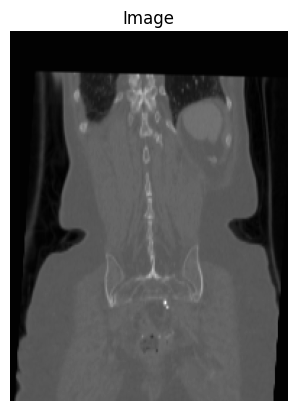

In [10]:
img = 0
depth = 40

img1 = load_nifti(train_images[img])

print(img1.shape)

plt.imshow(img1[:, :, depth], cmap='gray')
plt.title("Image")
plt.axis("off")

In [108]:
class AbdomenCTDataset(Dataset):
    def __init__(self, image_paths, downsample=False, scale_factor=0.5):
        self.image_paths = image_paths
        self.downsample = downsample
        self.scale_factor = scale_factor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        moving_image = load_nifti(self.image_paths[idx])
        rand_idx = random.randint(0, len(self.image_paths) - 1)
        fixed_image = load_nifti(self.image_paths[rand_idx])

        # Convert to torch tensors and add channel dimension
        mov_img = torch.tensor(moving_image, dtype=torch.float32)
        fix_image = torch.tensor(fixed_image, dtype=torch.float32)

        if self.downsample:
            mov_img = downsample_image(mov_img, scale_factor=self.scale_factor)
            fix_image = downsample_image(fix_image, scale_factor=self.scale_factor)

        mov_img = unsqueeze_tensor(mov_img, dim=4)

        fix_image = unsqueeze_tensor(fix_image, dim=4)

        return fix_image, mov_img


# Create Dataset Instances
train_dataset = AbdomenCTDataset(train_images, downsample=True, scale_factor=0.5)
val_dataset = AbdomenCTDataset(val_images, downsample=True, scale_factor=0.5)
test_dataset = AbdomenCTDataset(test_images, downsample=True, scale_factor=0.5)


In [109]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [116]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.bottleneck = self.conv_block(512, 1024)

        # Notice the change in in_channels for the decoders
        self.dec4 = self.upconv_block(1024 + 512, 512)
        self.dec3 = self.upconv_block(512 + 256, 256)
        self.dec2 = self.upconv_block(256 + 128, 128)
        self.dec1 = self.upconv_block(128 + 64, 64)
        
        self.out_conv = nn.Conv3d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool3d(enc1, 2))
        enc3 = self.enc3(F.max_pool3d(enc2, 2))
        enc4 = self.enc4(F.max_pool3d(enc3, 2))
        
        bottleneck = self.bottleneck(F.max_pool3d(enc4, 2))
    
        # Upsample the bottleneck to match the size of enc4 before concatenation
        bottleneck = F.interpolate(bottleneck, size=enc4.shape[2:], mode='trilinear', align_corners=True)
        
        dec4 = self.dec4(torch.cat((bottleneck, enc4), dim=1))
        dec3 = self.dec3(torch.cat((dec4, enc3), dim=1))
        dec2 = self.dec2(torch.cat((dec3, enc2), dim=1))
        dec1 = self.dec1(torch.cat((dec2, enc1), dim=1))
    
        out = self.out_conv(dec1)
        return out


# Instantiate Model
model = UNet(in_channels=2, out_channels=3).cuda()

In [117]:
# Define Loss Functions
def mse_loss(warped, fixed):
    return torch.mean((warped - fixed) ** 2)


def gradient_loss(flow):
    dx = torch.abs(flow[:, :, 1:, :, :] - flow[:, :, :-1, :, :])
    dy = torch.abs(flow[:, :, :, 1:, :] - flow[:, :, :, :-1, :])
    dz = torch.abs(flow[:, :, :, :, 1:] - flow[:, :, :, :, :-1])
    return torch.mean(dx) + torch.mean(dy) + torch.mean(dz)


# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [118]:
# Initialize lists to store loss values
train_losses = []
val_losses = []

num_epochs = 100  # Adjust as needed
smoothness_reg = 1.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for fixed_image, moving_image in train_loader:
        fixed_image, moving_image = fixed_image.cuda(), moving_image.cuda()

        optimizer.zero_grad()
        flow = model(torch.cat((fixed_image, moving_image), dim=1))
        warped_image = stn(moving_image, flow)

        loss_sim = mse_loss(warped_image, fixed_image)
        loss_reg = gradient_loss(flow)
        loss = loss_sim + smoothness_reg * loss_reg  # Adjust the weighting factor as needed

        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation Loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for fixed_image, moving_image in val_loader:
            fixed_image, moving_image = fixed_image.cuda(), moving_image.cuda()
            flow = model(torch.cat((fixed_image, moving_image), dim=1))
            warped_image = stn(moving_image, flow)

            loss_sim = mse_loss(warped_image, fixed_image)
            loss_reg = gradient_loss(flow)
            loss = loss_sim + smoothness_reg * loss_reg

            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


C:\Users\Tilmann\AppData\Local\Temp\ipykernel_5948\763220947.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tensor = torch.tensor(image, dtype=torch.float32)
C:\Users\Tilmann\AppData\Local\Temp\ipykernel_5948\763220947.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tensor = torch.tensor(image, dtype=torch.float32)


torch.Size([1, 1, 256, 192, 160])
torch.Size([1, 1, 256, 192, 160])
torch.Size([1, 128, 96, 80])
torch.Size([1, 128, 96, 80])


F:\git\CV\MedicalImageRegistration\.venv\Lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


RuntimeError: The size of tensor a (80) must match the size of tensor b (160) at non-singleton dimension 4

In [ ]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.eval()
test_loss = 0
with torch.no_grad():
    for fixed_image, moving_image in test_loader:
        fixed_image, moving_image = fixed_image.cuda(), moving_image.cuda()
        flow = model(torch.cat((fixed_image, moving_image), dim=1))
        warped_image = stn(moving_image, flow)

        loss_sim = mse_loss(warped_image, fixed_image)
        loss_reg = gradient_loss(flow)
        loss = loss_sim + smoothness_reg * loss_reg

        test_loss += loss.item()

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')


In [ ]:
# Visualization
model.eval()
with torch.no_grad():
    for fixed_image, moving_image in test_loader:
        fixed_image, moving_image = fixed_image.cuda(), moving_image.cuda()
        flow = model(torch.cat((fixed_image, moving_image), dim=1))
        warped_image = stn(moving_image, flow)

        # Visualization
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.title('Fixed Image')
        plt.imshow(fixed_image[0, 0, :, :, fixed_image.shape[4] // 2].cpu(), cmap='gray')

        plt.subplot(1, 3, 2)
        plt.title('Moving Image')
        plt.imshow(moving_image[0, 0, :, :, moving_image.shape[4] // 2].cpu(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title('Warped Image')
        plt.imshow(warped_image[0, 0, :, :, warped_image.shape[4] // 2].cpu(), cmap='gray')

        plt.show()
        break  # Only show for the first image pair


In [ ]:
torch.save(model.state_dict(), 'voxelmorph_pytorch.pth')

In [ ]:
model.load_state_dict(torch.load('voxelmorph_pytorch.pth'))
model.eval()  # Set the model to evaluation mode